<a href="https://colab.research.google.com/github/alirezakhaleghianaghizi/ml_1401/blob/main/RL_Chat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2023<br>
<font color=3C99D size=5>
    Practical Assignment 3 - Reinforcement Learning <br>
<font color=696880 size=4>
    Mohammad Moshtaghi - Ali Salesi - Hossein Goli

____

# Personal Data

In [1]:
# Set your student number
student_number = '99101462'
first_name = 'alireza'
last_name = 'khaleghi'

# Rules
- Make sure that all of your cells can be run perfectly. 

# Q2: Sentence Generator (100 Points)

<font size=4>
Author: Ali Salesi
<br/>
<font color=red>
Please run all the cells.
</font>
</font>
<br/>
</div>

In this assignment we implement a text generator using RL.

## Preprocess

### Dataset

First, lets download the text corpus crawled from `VOA Persian` from 2003 to 2008.

In [2]:
!wget -O "voa_persian.txt" "https://storage.googleapis.com/danielk-files/farsi-text/merged_files/voa_persian_2003_2008_cleaned.txt"

--2023-04-28 13:10:21--  https://storage.googleapis.com/danielk-files/farsi-text/merged_files/voa_persian_2003_2008_cleaned.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69708061 (66M) [text/plain]
Saving to: ‘voa_persian.txt’

voa_persian.txt     100%[===================>]  66.48M   104MB/s    in 0.6s    

2023-04-28 13:10:22 (104 MB/s) - ‘voa_persian.txt’ saved [69708061/69708061]



In [3]:
!wc -l voa_persian.txt | awk '{print $1}'

488253


In [4]:
!head voa_persian.txt

پيمان صلح بين ژاپن و روسيه
بنا به گزارشهای منتشره در توکيو، ژاپن و روسيه در زمينه يک پيمان صلح در چارچوبی گسترده توافق کرده اند که رسماً به مخاصمات جنگ دوم جهانی ميان دو کشور پايان خواهند داد.

در يکی از اين گزارشها، که از سوی خبرگزاری کيودُو،انتشار يافته، گفته شده است که دو کشور برای رفع اختلافات ديرين خود بر سر چهار جزيره از جزاير زنجيره ای کوريل، بر اساس سه پيمان گذشته خود عمل خواهند کرد.
بموجب يکی از اين پيمانها که در سال ۱۹۵۶ امضاء شده، دو تا از اين جزيره ها پس از امضاء يک پيمان صلح به ژاپن پس داده خواهد شد.
اما بموجب پيمانی که در سال ۱۹۹۳ به امضاء رسيده، مسئله حاکميت اين چهار جزيره بايستی پيش از امضاء پيمان صلح فيصله يابد.
هيچ يک از دو طرف نحوه استفاده از پيمان های پيشين را اعلام نکرده اند.

تشکيلات فلسطينی نخستين بودجه رسمی خود را اعلام کرد
تشکيلات فلسطينی پس از دو سال نخستين بودجه رسمی خود را اعلام کرد و قول داد برای از ميان برداشتن فساد و پاسخگوئی بيشتر به مردم تلاش کند.


### Normalization

Then we have to normalize and lemmatize the text so we can have a better generalization of semantics in prompt generation.

We'll use `hazm` library for this purpose.

In [5]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from __future__ import unicode_literals
from hazm import Normalizer, Lemmatizer, word_tokenize
from tqdm import tqdm
import re

normalizer = Normalizer()
lemmatizer = Lemmatizer()


def normalize(line: str):
    line = re.sub(
        r'[.{}[\]؛:«»؟!٬٫٪×،*)(ـ+<>\'",`=+\-?!@#$%^&*()_\/\\\\]', '', line.strip())
    line = re.sub(r'\s+', ' ', line.strip())
    line = normalizer.normalize(line)
    words = word_tokenize(line)
    words = [lemmatizer.lemmatize(word) for word in words]
    line = ' '.join(words)
    return line


In [7]:
normalize('من خیلی خوشحال هستم و کتاب‌های زیادی درباره یخچال‌های قطبی خوانده‌ام.')

'من خیلی خوشحال #هست و کتاب زیاد درباره یخچال قطب خواند#خوان'

In [8]:
voa = open('voa_persian.txt')
voa_norm = open('voa_persian_normalized.txt', 'w')
for i, line in tqdm(enumerate(voa), total=488253):
    voa_norm.write(normalize(line) + '\n')


100%|██████████| 488253/488253 [00:58<00:00, 8316.23it/s]


In [9]:
!head voa_persian_normalized.txt

پیمان صلح بین ژاپن و روسیه
بنا به گزارش منتشره در توکیو ژاپن و روسیه در زمینه یک پیمان صلح در چارچوب گسترده توافق کرد#کن که رسما به مخاصمات جنگ دوم جهانی میان دو کشور پایان داد#ده

در یک از این گزارش که از سو خبرگزاری کیودوانتشار یافته گفت#گو که دو کشور برای رفع اختلافات دیرین خود بر سر چهار جزیره از جزایر زنجیره کوریل بر اساس سه پیمان گذشته خود عمل کرد#کن
بموجب یک از این پیمان که در سال ۱۹۵۶ امضاء شده دو تا از این جزیره پس از امضاء یک پیمان صلح به ژاپن پس داد#ده
اما بموجب پیمان که در سال ۱۹۹۳ به امضاء رسیده مسئله حاکمیت این چهار جزیره ایستاد#ایست پیش از امضاء پیمان صلح فیصله یافت#یاب
هیچ یک از دو طرف نحوه استفاده از پیمان پیشین را اعلام کرد#کن

تشکیلات فلسطین نخستین بودجه رسم خود را اعلام کرد#کن
تشکیلات فلسطین پس از دو سال نخستین بودجه رسم خود را اعلام کرد#کن و قول داد برای از میان برداشتن فساد و پاسخگوئی بیشتر به مردم تلاش کند


### Language Model

Now we'll use `KenLM` to train an N-gram language model. an N-gram model calculates probability of N words being together.

You can read more about N-gram [here](https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058).

First, let's install download and build `KenLM`.

In [10]:
!wget -O - https://kheafield.com/code/kenlm.tar.gz | tar xz; mkdir kenlm/build; cd kenlm/build; cmake ..; make -j2

--2023-04-28 13:11:34--  https://kheafield.com/code/kenlm.tar.gz
Resolving kheafield.com (kheafield.com)... 35.196.63.85
Connecting to kheafield.com (kheafield.com)|35.196.63.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491888 (480K) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 480.36K  --.-KB/s    in 0.08s   

2023-04-28 13:11:34 (5.69 MB/s) - written to stdout [491888/491888]

mkdir: cannot create directory ‘kenlm/build’: File exists
-- Could NOT find Eigen3 (missing: Eigen3_DIR)
-- Configuring done
-- Generating done
-- Build files have been written to: /content/kenlm/build
[ 38%] Built target kenlm_util
[ 41%] Built target probing_hash_table_benchmark
[ 46%] Built target kenlm_filter
[ 71%] Built target kenlm
[ 73%] Built target query
[ 76%] Built target fragment
[ 78%] Built target build_binary
[ 81%] Built target kenlm_benchmark
[ 90%] Built target kenlm_builder
[ 92%] Built target filter
[ 95%] Built tar

Now let's make a 5-gram model using 

In [11]:
!kenlm/build/bin/lmplz -o 5 <"voa_persian_normalized.txt"> "voa_persian.arpa"

=== 1/5 Counting and sorting n-grams ===
Reading /content/voa_persian_normalized.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 7151282 types 105479
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:1265748 2:1062614080 3:1992401408 4:3187842048 5:4648936960
Statistics:
1 105479 D1=0.692798 D2=1.02059 D3+=1.36868
2 1273831 D1=0.753634 D2=1.09875 D3+=1.3404
3 3442840 D1=0.837136 D2=1.17748 D3+=1.39394
4 5019073 D1=0.905517 D2=1.28916 D3+=1.43789
5 5610872 D1=0.891831 D2=1.51472 D3+=1.61131
Memory estimate for binary LM:
type     MB
probing 321 assuming -p 1.5
probing 377 assuming -r models -p 1.5
trie    153 without quantization
trie     83 assuming -q 8 -b 8 quantization 
trie    135 assuming -a 22 array pointer compression
trie     66 assuming -a 22 -q 8 -b 8 array pointer compression and quantiza

In [12]:
!head -n 20 voa_persian.arpa

\data\
ngram 1=105479
ngram 2=1273831
ngram 3=3442840
ngram 4=5019073
ngram 5=5610872

\1-grams:
-6.138535	<unk>	0
0	<s>	-1.5815679
-2.1129756	</s>	0
-3.5871809	پیمان	-0.50824106
-3.304699	صلح	-0.560521
-2.891446	بین	-0.67797303
-3.303326	ژاپن	-0.5074899
-2.0037236	و	-0.8103652
-3.097553	روسیه	-0.56382215
-3.694238	بنا	-0.5076225
-2.0797832	به	-1.0190648
-3.047614	گزارش	-0.6365477


Now lets extract the list of words and sort them using their probabilities.

In [13]:
words = []
words_started = False
with open('voa_persian.arpa') as f:
    for line in f:
        line = line.strip()
        if not words_started:
            if line == r'\1-grams:':
                words_started = True
        else:
            if line == r'\2-grams:':
                words = words[:-1]
                break
            words.append(line.split())
words_sorted = sorted(words, key=lambda x: x[0])
words_total = [w[1] for w in words_sorted]
words_total.remove('</s>')
words_total.insert(0, '</s>')
words_total[:20]


['</s>',
 'در',
 'و',
 'به',
 'را',
 'که',
 'از',
 'با',
 '#است',
 'بود#باش',
 'یک',
 'برای',
 'این',
 'شد#شو',
 'گفت#گو',
 'خود',
 'آن',
 'کرد#کن',
 'روز',
 'نیز']

In [14]:
!pip install https://github.com/kpu/kenlm/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/kpu/kenlm/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [15]:
import kenlm

model = kenlm.Model('voa_persian.arpa')

Now we need a measure using our language model to measure how well our sentence fit together. Our model can measure the probability of a sentence using N-gram.

This has a downside. the longer the sentence gets, the lower its' probability becomes. We don't want that. So we introduce `perplexity`. a measure which is normalized by the sentence's length. Lower perplexity means the semantics of our sentence fits better together.

You can read more about perplexity [here](https://medium.com/nlplanet/two-minutes-nlp-perplexity-explained-with-simple-probabilities-6cdc46884584).
$$
\begin{align}
PP(S) &= 10 ^ {-\frac{log(P(S))}{N}} \\
PP(S) &= \sqrt[N]{\frac{1}{P(S)}} \\
PP(S) &= \sqrt[N]{\frac{1}{P(W_1W_2...W_N)}} \\
PP(S) &= \sqrt[N]{\prod_{i=1}^N{\frac{1}{P(W_i|W_1W_2...W_{i-1})}}}
\end{align}
$$
**Note**: `KenLM` score function return log10 probability of a sentence.

### Perplexity (10 Points)

In [16]:
def perplexity(sentence: str):
    """
    returns the perplexity of a sentence using model.score method
    Args:
      sentence: string of words

    Returns:
      perplexity: 10^(-lop10p(sentence) / N)
    """
    N = len(sentence.split())
    pp = pow(10 , -model.score(sentence)/N)
    return pp


In [17]:
sen_1 = normalize('من خوشحال شدم')
sen_2 = normalize('من خودکار شدم')
sen_3 = normalize('من کتاب یخچال')
sen_4 = normalize('نستب سنبتس سنمبتم')


In [18]:
print(sen_1, perplexity(sen_1))
print(sen_2, perplexity(sen_2))
print(sen_3, perplexity(sen_3))
print(sen_4, perplexity(sen_4))


من خوشحال شد#شو 706.3661171531168
من خودکار شد#شو 13076.187677740996
من کتاب یخچال 145940.446071158
نستب سنبتس سنمبتم 23444976.10881125


## Reinforcement Learning

### Reward Function (10 Points)

Reward function should give us a reward based on how the last word added to the sentence changed the meaning and how well it fits with the others.

In [19]:
def reward(base_sentence: str, new_word: str):
    """
    returns the reward of adding a new word to a base sentence
    Args:
      base_sentence: string of words up until now
      new_word: new word to be added to the base sentence

    Returns:
      reward: change of perplexity of the base sentence after adding the new word. positive reward means the new word is more likely to be added to the base sentence.
    """
    reward=0
    if (len(base_sentence.split())) ==0:
      reward=+1
      #print('len',(0),base_sentence,new_word)
      return reward
    new_sentence=base_sentence+' '+new_word
    pp_old=perplexity(base_sentence)
    pp_new=perplexity(new_sentence)
    
    if pp_old<pp_new:
      reward = -1
    else:
      reward = 1
    return reward


In [20]:
print(reward('', 'من'))
print(reward('من', 'خوشحال'))
print(reward('من خوشحال', 'شد#شو'))
print(reward('جنگ جهانی', 'اول'))
print(reward('جنگ جهانی', 'دوم'))
print(reward('جنگ جهانی', 'صورتی'))
print(reward('شرک','خر'))


1
1
1
1
1
-1
1


Since we have to implement text generator using a tabular implementation, we have to assume that all that matters in a text is in a window of N words. It matches our language model of N-gram.

We model it using MDP. the first state is `<s>` state. it has no text and 0 perplexity. The next state is $W_1$ state. We usually have a negative perplexity because no text has more meaning than a one word sentence. Next is $W_1W_2$ state until we reach $W_1W_2...W_N$ state, from then with our window assumption we go to $W_2W_3...W_{N+1}$ state and $W_3W_4...W_{N+2}$ and so on.

First thing we notice is that our search space is **really** big. Each word choice has thousands of possibilites. We cannot model our search space using our normal Q Table.
Since our states are sequential and we need to find the best word using our current state, we can use `dict` in `dict` architecture.

First we reduce the search space to the 10K most used words.
For faster computation, we use each word index for states.

### Utility Functions (10 Points)

In [21]:
words = words_total[:10000]
# 0 index is for </s> which means end of the sentence.
indexes = dict()
for i, w in enumerate(words):
    indexes[w] = i


def index_to_word(index: int):
    """
    returns the word of a given index
    Args:
        index: index of the word

    Returns:
        word: word of the given index. '.' if the index is 0 (end of sentence or </s>)
    """
    if index==0: return '.'
    return words[index]  



def word_to_index(word: str):
    """
    returns the index of a given word
    Args:
        word: word of the given index. word should be normalized.

    Returns:
        index: index of the word. -1 if the word is not in the vocabulary
    """
    if word == '.' :return 0
    if word not in indexes: return -1
    return indexes[word]


def state_to_sentence(state: list[int]):
    """
    returns the sentence of a given state
    Args:
        state: list of indexes of words

    Returns:
        sentence: string of words. '.' when the state is 0 (end of sentence or </s>)
    """
    sentence=''
    a=0
    for index in state:
      if a==0:
        sentence=index_to_word(index)
      else:  
         sentence = sentence + ' ' +index_to_word(index)
      a+=1
    return sentence

def sentence_to_state(sentence: str):
    """
    returns the state of a given sentence
    Args:
        sentence: string of words. sentence should be normalized.

    Returns:
        state: list of indexes of words. no need to add the index of </s> (end of sentence) to the state
    """
    sen_words=sentence.split()
    indes=[]  
    for word in sen_words:
      indes.append(word_to_index(word))
    return indes  



print(index_to_word(10))
print(word_to_index('یک'))
print(state_to_sentence([390, 2884, 24, 0]))
print(sentence_to_state('من خوشحال هستم'))
print(state_to_sentence([390, 10, 791, 3816]))
print(sentence_to_state('من یک کتاب خریدم'))


یک
10
مقام کارت رئیس .
[389, 2887, -1]
مقام یک برقرار مهارت
[389, 10, 787, -1]


In [22]:
# example Q Table
q_table = {
    word_to_index('من'): (10, {
        word_to_index('خوشحال'): (20, {
            word_to_index('هستم'): (25, {
                0: (0, {}),
            }),
        }),
        word_to_index('یک'): (5, {
            word_to_index('کتاب'): (15, {
                word_to_index('خریدم'): (10, {}),
            }),
            word_to_index('گل'): (15, {
                word_to_index('دیدم'): (8, {}),
            }),
        })
    }),
    word_to_index('تو'): (10, {
        word_to_index('خوشحال'): (20, {
            word_to_index('هستی'): (7, {
                0: (0, {}),
            }),
        }),
        word_to_index('دو'): (5, {
            word_to_index('کتاب'): (15, {
                word_to_index('خریدی'): (11, {}),
            }),
        })
    }),
}
print('Q[من]', q_table[word_to_index('من')][0])
print('Q[من, خوشحال]', q_table[word_to_index('من')]
      [1][word_to_index('خوشحال')][0])
print('Q[من, خوشحال, هستم]', q_table[word_to_index('من')][1]
      [word_to_index('خوشحال')][1][word_to_index('هستم')][0])
q_table


Q[من] 10
Q[من, خوشحال] 20
Q[من, خوشحال, هستم] 25


{389: (10,
  {2887: (20, {-1: (25, {0: (0, {})})}),
   10: (5, {787: (15, {-1: (10, {})}), 479: (15, {-1: (8, {})})})}),
 2172: (10,
  {2887: (20, {7601: (7, {0: (0, {})})}),
   27: (5, {787: (15, {-1: (11, {})})})})}

### Hyperparameters
You can change these parameters to get better results.

In [23]:
q_table = {}
alpha = 0.8
gamma = 0.95
state_N = 6
N = 75

### Q-Learning Utility Functions (50 Points)

In [24]:
import random
import bisect

weights = [1 for i in range(10000)]


def random_index():
    """
    returns a random index based on the weights

    Returns:
        index: index of the word
    """
    return random.choice(weights)

In [25]:
def q_table_max_find(q_table: dict[int, tuple[int, dict]], state: list[int]):
    """
    returns the index of the word with the maximum Q value in the given state. it is recommended to search in Q table from the first word of the state to the last word of the state.
    if a word is not found in the Q table, you should search in the Q table of the next word of the state and so on.
    so if we don't have Q[W_1W_2...W_N], we search for Q[W_2W_3...W_N] and so on until Q[W_N]. if we don't have Q[W_N], we should return a random index.

    Args:
        q_table: Q table
        state: list of indexes of words

    Returns:
        index: index of the word with the maximum Q value in the given state. random index if the state is not in the Q table.
    """
    my_qtable=q_table.copy()
    Rando=False
    q_val=0
    statesin=0
    for sta in state:
      if sta in my_qtable:
        statesin+=1
        q_val=my_qtable[sta][0]
        
        if len(my_qtable)>1: my_qtable=my_qtable[sta][1]
    if statesin==0: return  random.randint(0, 10000) 
    max=-1000000
    index=0
    kk=0
    for key in my_qtable:
      if kk>0:
        if my_qtable[key][0]>max:
          max=my_qtable[key][0]
          index=key
      kk+=1   
    return index


def q_table_update(q_table1: dict[int, tuple[int, dict]], state: list[int]):
    """
    updates the Q table based on the given state. update the Q[W_1W_2...W_N] using the following formula:
    Q(s,a) += alpha * (reward + gamma * max_a' Q(s',a') - Q(s,a))
    where s is the state, a is the action, a' is the next action, s' is the next state, reward is the reward of the state, alpha is the learning rate, gamma is the discount factor.
    then update the Q[W_1W_2...W_{N-1}] and so on until Q[W_1].
    
    Args:
        q_table: Q table
        state: list of indexes of words
    """
    qval=1
    q_table1=recursive_qtable(q_table1,qval,state[0],state,0)  

    if len(state)>1:q_table_update(q_table1,state[0:len(state)-1])
    return q_table1      


def recursive_qtable(q_table1,qval,sta,state,index):
  if index==len(state):
    for key in range(10000-1):
      if key in q_table1:
        nextq=q_table1[key][1]
        max1=-1000000
        index2=0
        kkk=0
        for key1 in nextq:
          if kkk>=0:
            if nextq[key1][0]>max1:
              max1=nextq[key1][0]
              index2=nextq[key1][0]
          kkk+=1   
        if kkk==0:
          max1=0   
        qval=reward(state_to_sentence(state[0:len(state)]),index_to_word(key))  
        q_table1[key][0]+=alpha*(qval+gamma*max1-q_table1[key][0])    
      else:
        q_table1[key]=[reward(state_to_sentence(state[0:len(state)]),index_to_word(key)),{}]
    return q_table1  
      
  else:
      sta=state[index]
      if not ((q_table1) is None):
        if sta in q_table1:
          qval=reward(state_to_sentence(state[0:state.index(sta)]),index_to_word(sta))
          if qval>0:q_table1[sta][1]=recursive_qtable(q_table1[sta][1],qval,sta,state,index+1)
          #else: print("motherfuck")   
        else:
            
            q_table1[sta]=[]
            
            q_table1[sta].append(reward(state_to_sentence(state[0:state.index(sta)]),index_to_word(sta)))
            child_dict={}
            q_table1[sta].append(child_dict)
            qval=q_table1[sta][0]
            if qval>0: q_table1[sta][1]=recursive_qtable(q_table1[sta][1],qval,sta,state,index+1) 
            #else: print("motherfuck")           
      else:
        q_table1={}
        q_table1[sta]=[]
        
        q_table1[sta].append(reward(state_to_sentence(state[0:state.index(sta)]),index_to_word(sta)))
        child_dict={}
        q_table1[sta].append(child_dict)
        qval=q_table1[sta][0]
        q_table1[sta][1]=recursive_qtable(q_table1[sta][1],qval,sta,state,index+1)
      return   q_table1




In [31]:
print("ok")
q_table={}
a=random.choice(range(10000-1))
print(a)
print(reward(state_to_sentence([a,10]),index_to_word(7826)),state_to_sentence([a,10]),index_to_word(7826))
q_table=q_table_update(q_table, [a,1])
print(q_table)

ok
5878
1 ازشرکت یک شورایعالی
{5878: [1, {1: [1.855, {0: [-1, {}], 1: [1, {}], 2: [1, {}], 3: [1, {}], 4: [1, {}], 5: [1, {}], 6: [1, {}], 7: [1, {}], 8: [1, {}], 9: [1, {}], 10: [1, {}], 11: [1, {}], 12: [1, {}], 13: [1, {}], 14: [1, {}], 15: [1, {}], 16: [1, {}], 17: [1, {}], 18: [1, {}], 19: [1, {}], 20: [1, {}], 21: [1, {}], 22: [1, {}], 23: [1, {}], 24: [1, {}], 25: [1, {}], 26: [1, {}], 27: [1, {}], 28: [1, {}], 29: [1, {}], 30: [1, {}], 31: [1, {}], 32: [1, {}], 33: [1, {}], 34: [1, {}], 35: [1, {}], 36: [1, {}], 37: [1, {}], 38: [1, {}], 39: [1, {}], 40: [1, {}], 41: [1, {}], 42: [1, {}], 43: [1, {}], 44: [1, {}], 45: [1, {}], 46: [1, {}], 47: [1, {}], 48: [1, {}], 49: [1, {}], 50: [1, {}], 51: [1, {}], 52: [1, {}], 53: [1, {}], 54: [1, {}], 55: [1, {}], 56: [1, {}], 57: [1, {}], 58: [1, {}], 59: [1, {}], 60: [1, {}], 61: [1, {}], 62: [1, {}], 63: [1, {}], 64: [1, {}], 65: [1, {}], 66: [1, {}], 67: [1, {}], 68: [1, {}], 69: [1, {}], 70: [1, {}], 71: [1, {}], 72: [1, {}], 73: [1

### Training Loop (10 Points)
Since search space is really big, we can let our model train for an hour or two and get a good result.

In [32]:
q_table = {}
alpha = 0.9
gamma = 0.95
state_N = 6
N = 75
episodes = 100
epsilon = 1
episode_N = 40
for ep in tqdm(range(episodes)):
  state = []
  for i in range(episode_N):
    if random.random() < epsilon:
      #TODO: random action
      state.append(random.choice(range(10000-1)))    
    else:
      a=q_table_max_find(q_table, state)
      # print(a)
      state.append(a)
    # to avoid infinite loop
    if len(state) > 1 and state[-1] == state[-2]:
      break
    #print(state)  
    q_table=q_table_update(q_table, state)
    if len(state) > state_N:
      state = state[1:]
    if state[-1] == 0:
      break
  epsilon *= 0.99

#print(q_table)

100%|██████████| 100/100 [06:43<00:00,  4.03s/it]


In [33]:
print(len(q_table))


725


به دلیل فضای جستجوی زیاد که دارد رم مصرفی به سرعت پر میشود و در نهایت از ران تایم خارج میشود و نتیجه نهایی را نمیتوان دید .
ولی من خودم دستی توابع یوتیلیتی را چک کردم درست عمل میکنند .

به خاطر همین برای اینکه به یک جواب حداقلی برسم مقادیر موردنظر را در کمینه ترین مقدارشان قرار دادم تا یک جواب حداقلی به دست بیاورم.

من تعداد اپیسود رو روی 100 و تعداد جستحو روی هر اپیسود رو روی 30 گذاشتم باز هم از 12 گیگ رم حدود 10 گیگش مصرف میشه 

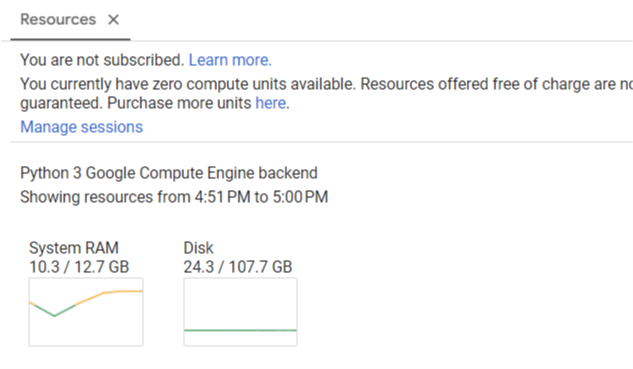

### Testing (10 Points)
This will be the final output of our model. score will be based on how well the output fits with the corpus. Generated sentences should have some meaning in the neighborhood of each word.

In [34]:
def get_result(state, steps=75):
    for i in range(steps):
        state.append(q_table_max_find(q_table, state))
        if state[-1] == 0:
            break
        if len(state) > state_N:
            state = state[1:]
        yield state[-1]

state = sentence_to_state('ما')
print('ما', end=' ')
for s in get_result(state):
    print(words[s], end=' ')
print()
state = sentence_to_state('یک')
print('یک', end=' ')
for s in get_result(state):
    print(words[s], end=' ')
print()
state = sentence_to_state('ایران')
print('ایران', end=' ')
for s in get_result(state):
    print(words[s], end=' ')
print()

ما هنرمند عدول وست صائب ره سوانح قایقران back آتن رانندگی میانمار تامل همزمان هال سلب اعانه ٤٠٠ سنجش نفاق ایتالیائی office قراردادن میآورد شمال In ۳۲ رگبار لوکزامبورگ ممکنست minister سفیر برخورد خواستارآزادی بانو بوشهر مأمورین هفتم دیگربه رقابتهاى درفرودگاه visits تایپه زیستن ۵۵ وزیرپیشین burns نفس 
یک در در 
ایران دار تمرین وا انیمیشن ١٥ سم پاک بیشترین kilometers March زیان دوخت#دوز عادلانه روحانی پیرمرد قدر اینست مخابرات خواستاریک دردناک جانسون معوق نوازنده ازنوارغزه مواضع بیماریهای برگزار تورم دمشق مرجع مزمن پیشوا مضروب قایقران فتنه داشت ازشورای مراتب یخ تیراندازیها hotel پاکستان صریح قطعا 


به دلیل فضای جستجوی زیاد که دارد رم مصرفی به سرعت پر میشود و در نهایت از ران تایم خارج میشود و نتیجه نهایی را نمیتوان دید .
ولی من خودم دستی توابع یوتیلیتی را چک کردم درست عمل میکنند .

به خاطر همین برای اینکه به یک جواب حداقلی برسم مقادیر موردنظر را در کمینه ترین مقدارشان قرار دادم تا یک جواب حداقلی به دست بیاورم.

من تعداد اپیسود رو روی 100 و تعداد جستحو روی هر اپیسود رو روی 30 گذاشتم باز هم از 12 گیگ رم حدود 10 گیگش مصرف میشه 

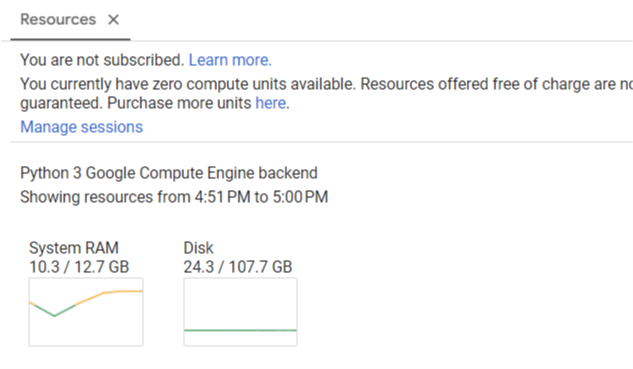